### <a id='e'></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:350%;text-align:center;border-radius:15px 50px;padding:7px'> Rice Classification CNN by Tensorflow</h1>

### Table of contents:

* [1. Import Libraries](#1)
* [2. Preparing Dataset](#2)
* [3. MODEL 1](#3)
* [4. MODEL 2](#4)
* [5. MODEL 3](#5)
* [6. MODEL 4](#6)
* [7. MODEL 5](#7)
* [8. Comparsion](#8)

<a id="1"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> Import Libraries</h1>

In [1]:
# insatll requirement tools and libraries
!pip install split-folders
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-4k1jh270
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-4k1jh270
  Resolved https://github.com/tensorflow/docs to commit 75b2672b5bed8ca0995663536db84bd9a39b8896
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.5.3.31743-py3-none-any.whl size=186593 sha256=0d28bbf76f376a624202c30a6b8d73999d18b7fc78656e648aef107c42b66345
  Stored in directory: /tmp/pip-ephem-wheel-cache-0sioc8ly/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [2]:
# import requirement libraries and tools
import os
import pathlib
import itertools
import numpy as np
import pandas as pd
import splitfolders
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore") 

2024-05-17 11:30:15.891506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 11:30:15.891682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 11:30:16.103146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="2"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> Preparing Dataset</h1>

In [3]:
# Set the path to the dataset
dataset_path = '/kaggle/input/Rice_Image_Dataset'
dataset_path = pathlib.Path(dataset_path)

# Initialize empty lists for storing the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in os.listdir(dataset_path):
    
    subfolder_path = os.path.join(dataset_path, subfolder)
    if not os.path.isdir(subfolder_path):
        continue
  
  # Loop over the images in the subfolder
    for image_filename in os.listdir(subfolder_path):
       # Load the image and store it in the images list
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
    
        # Store the label for the image in the labels list
        labels.append(subfolder)
 
 # Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Visualization of Dataset</p>

In [4]:
df.head()

,image,label
0,/kaggle/input/Rice_Image_Dataset/Karacadag/Kar...,Karacadag
1,/kaggle/input/Rice_Image_Dataset/Karacadag/Kar...,Karacadag
2,/kaggle/input/Rice_Image_Dataset/Karacadag/Kar...,Karacadag
3,/kaggle/input/Rice_Image_Dataset/Karacadag/Kar...,Karacadag
4,/kaggle/input/Rice_Image_Dataset/Karacadag/Kar...,Karacadag


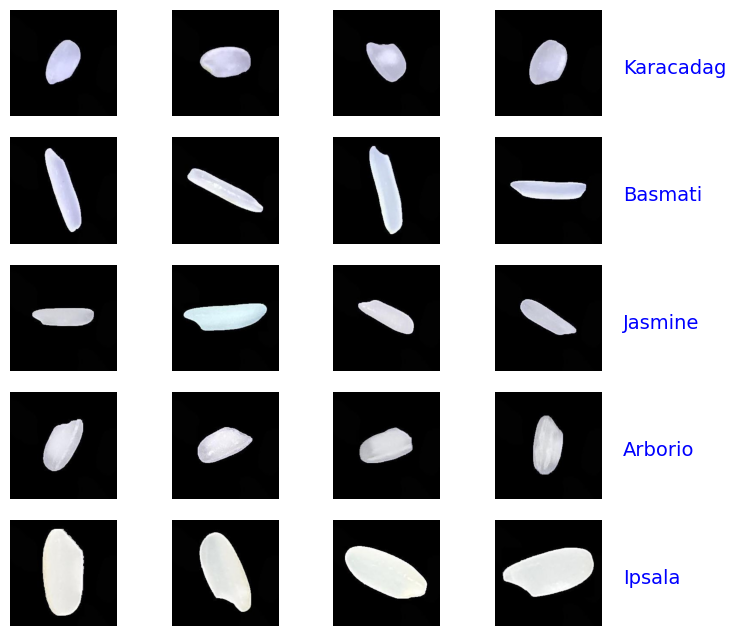

In [5]:
from matplotlib.gridspec import GridSpec
# Create figure and grid of subplots
fig = plt.figure(figsize=(8, 8))
gridspec = GridSpec(5, 4, figure = fig)

# Loop through each unique category in the DataFrame
for row, category in enumerate(df['label'].unique()):
    # Get the filepaths for the first four images in the category
    filepaths = df[df['label'] == category]['image'].values[:4]
    
    # Loop through the filepaths and add an image to each subplot
    for col, filepath in enumerate(filepaths):
        ax = fig.add_subplot(gridspec[row, col])
        ax.imshow(plt.imread(filepath))
        ax.axis('off')
    
    # Add a label to the bottom of the subplot grid
    ax.text(300, 150, category, fontsize = 14, color = 'blue')

plt.show()

## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Split Data into Train and Test</p>

In [6]:
splitfolders.ratio(input=dataset_path, output='rice_images', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [13:34, 92.08 files/s] 


## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Data Augmentation</p>

In [7]:
path_dir = '/kaggle/working/rice_images'
train_dir = os.path.join(path_dir, 'train')
val_dir = os.path.join(path_dir, 'val')
test_dir = os.path.join(path_dir, 'test')

# store training, validation and testing set from directory
batch_size = 32
# resize the images from the directories to prevent ResourceExhaustedError
image_size = (128, 128)

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for the training data
train_gen = image_gen.flow_from_directory(
    train_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
#     subset = 'training'
)

# Create a generator for the val data
validation_gen = image_gen.flow_from_directory(
    val_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
#     subset = 'validation'
)

# Create a generator for the test data
test_gen = image_gen.flow_from_directory(
    test_dir,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
)

class_names = list(train_gen.class_indices.keys())

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [8]:
# check class in each set
for i in [train_gen, validation_gen, test_gen]:
         print(i.class_indices)

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [9]:
datasets = [(train_gen, "Train_generator"), (validation_gen, "Validation_generator"), (test_gen, "Test_generator")]

for dataset, dataset_name in datasets:
    for image_batch, labels_batch in dataset:
        print(f"{dataset_name} Shape: {image_batch.shape} (Batches = {len(dataset)})")
        print(f"{dataset_name} Label: {labels_batch.shape}\n") 
        break

Train_generator Shape: (32, 128, 128, 3) (Batches = 1641)
Train_generator Label: (32, 5)

Validation_generator Shape: (32, 128, 128, 3) (Batches = 352)
Validation_generator Label: (32, 5)

Test_generator Shape: (32, 128, 128, 3) (Batches = 352)
Test_generator Label: (32, 5)



In [10]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     train_dir,
#     image_size=image_size,
#     batch_size=batch_size,
#     labels='inferred',
#     label_mode='int',
#     seed=42
# )

# validation_ds = tf.keras.utils.image_dataset_from_directory(
#     val_dir,
#     image_size=image_size,
#     batch_size=batch_size,
#     labels='inferred',
#     label_mode='int',
#     seed=42
# )

# test_ds = tf.keras.utils.image_dataset_from_directory(
#     test_dir,
#     image_size=image_size,
#     batch_size=batch_size,
#     labels='inferred',
#     label_mode='int',
#     seed=42
# )

## <p style="font-family:newtimeroman; font-weight:bold; letter-spacing: 1px; color:#701356; font-size:120%; text-align:left;padding: 10px; border-bottom: 3px solid #330928">Definition of functions</p>

In [11]:
def visualizing_results(model):
    
    font = {'family':'serif','size':12}
    epoch_count = range(1, len(model.history['loss']) + 1)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_count, model.history['accuracy'], label='Train Accuracy', color='b', marker='o')
    plt.plot(epoch_count, model.history['val_accuracy'], label='Validation Accuracy', color='orange', marker='d')
    plt.xlabel('Epoch', fontsize=10, labelpad=16)
    plt.ylabel('Accuracy', fontsize=10, labelpad=16)
    plt.title('Accuracy comparison between Validation and Train Dataset',
              backgroundcolor='black', color='white', fontdict=font, y=1.02)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epoch_count, model.history['loss'], label='Train Loss', color='b', marker='o')
    plt.plot(epoch_count, model.history['val_loss'], label='Validation Loss', color='orange', marker='d')
    plt.xlabel('Epoch', fontsize=10, labelpad=16)
    plt.ylabel('Loss', fontsize=10, labelpad=16)
    plt.title('Loss comparison between Validation and Train Dataset', 
              backgroundcolor='black', color='white', fontdict=font, y=1.02)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [12]:
# Evaluate the model on the test data
def model_evaluation(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data)

    print(f"Test loss: {test_loss:0.4f}")
    print(f"Test accuracy: {test_accuracy:0.4f}")

In [14]:
def true_and_pred_labels(dataset, model):
    
    all_true_labels = []
    all_predictions = []

    batch_count = 0

    for images, labels in dataset:
        if batch_count >= len(dataset):
            break

        # Use the model to predict the class
        class_probabilities = model(images, training=False)

        # The model returns a probability value for each class
        # The one with the highest probability is the predicted class
        predictions = tf.argmax(class_probabilities, axis=1).numpy()

        # The actual labels are hot encoded (e.g. [0 1 0 0 0], so get the one with the value 1
        true_labels = np.argmax(labels, axis=1)

        # Collect all true labels and predictions
        all_true_labels = np.append(all_true_labels, true_labels)
        all_predictions = np.append(all_predictions, predictions)

        batch_count += 1

    return all_true_labels, all_predictions

In [19]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    font = {'family':'serif','size':12}
    
    plt.figure(figsize=(6,6))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, backgroundcolor='black', color='white', fontdict=font, y=1.02)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

<a id="3"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> MODEL 1</h1>

In [16]:
input_shape = (128, 128, 3)

# Create a Sequential model1
model1 = Sequential()
model1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Flatten())
# model1.add(Dense(256, activation='relu'))
model1.add(Dense(train_gen.num_classes, activation='softmax'))
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │       635,045 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 635,941 (2.43 MB)

 Trainable params: 635,941 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
epochs_count = 5

# Train the model on the training data
m1 = model1.fit(train_gen, epochs=epochs_count, validation_data=validation_gen)

Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 543s 329ms/step - accuracy: 0.6979 - loss: 0.7993 - val_accuracy: 0.9164 - val_loss: 0.2464
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 549s 321ms/step - accuracy: 0.8974 - loss: 0.2730 - val_accuracy: 0.9305 - val_loss: 0.1882
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 566s 324ms/step - accuracy: 0.9190 - loss: 0.2199 - val_accuracy: 0.9402 - val_loss: 0.1667
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 562s 324ms/step - accuracy: 0.9252 - loss: 0.2041 - val_accuracy: 0.9398 - val_loss: 0.1633
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 563s 324ms/step - accuracy: 0.9277 - loss: 0.1989 - val_accuracy: 0.9334 - val_loss: 0.1860


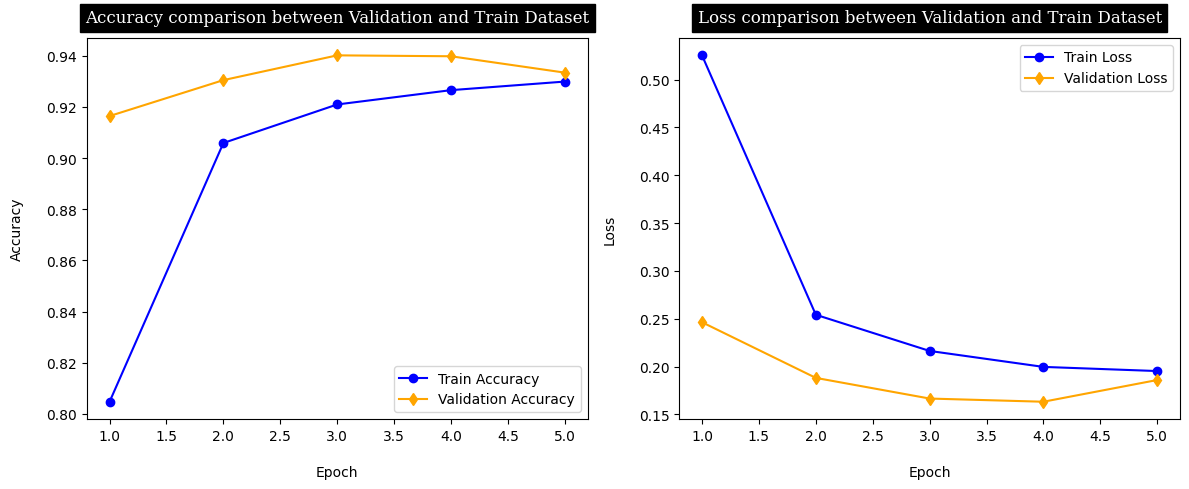

In [20]:
visualizing_results(m1)

In [21]:
classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

              precision    recall  f1-score   support

     Arborio       0.90      0.97      0.93      2249
     Basmati       0.99      0.85      0.92      2255
      Ipsala       1.00      0.99      0.99      2248
     Jasmine       0.84      0.93      0.88      2248
   Karacadag       0.98      0.93      0.96      2250

    accuracy                           0.94     11250
   macro avg       0.94      0.94      0.94     11250
weighted avg       0.94      0.94      0.94     11250
 




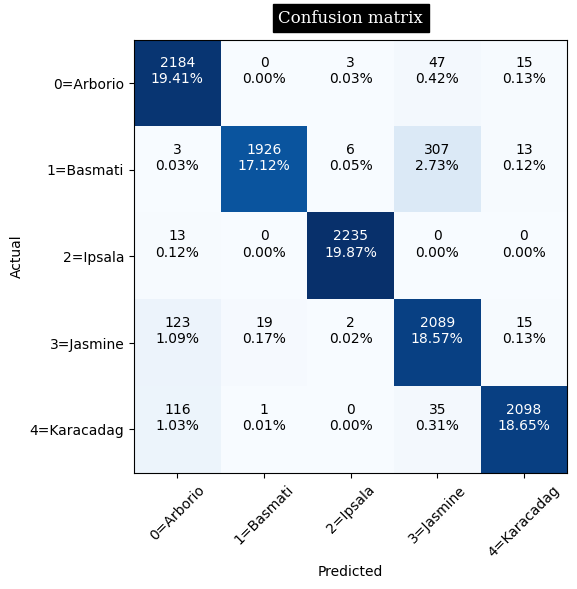

In [22]:
# plot confusion matrix for error analysis
true_labels, predictions = true_and_pred_labels(validation_gen, model1)

print(classification_report(true_labels, predictions, target_names=class_names), '\n\n')
cm = confusion_matrix(true_labels, predictions)

plot_confusion_matrix(cm, classes)

In [23]:
m1_acc = model_evaluation(model1, test_gen)

352/352 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - accuracy: 0.9373 - loss: 0.1838
Test loss: 0.1783
Test accuracy: 0.9380


<a id="4"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> MODEL 2</h1>

In [24]:
# Create a Sequential model2
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(train_gen.num_classes, activation='softmax'))
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,766,533 (56.33 MB)

 Trainable params: 14,766,533 (56.33 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
# Train the model on the training data
m2 = model2.fit(train_gen, epochs=epochs_count, validation_data=validation_gen)

Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1084s 659ms/step - accuracy: 0.7340 - loss: 0.6428 - val_accuracy: 0.8984 - val_loss: 0.2634
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1071s 640ms/step - accuracy: 0.9469 - loss: 0.1497 - val_accuracy: 0.9647 - val_loss: 0.1038
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1047s 637ms/step - accuracy: 0.9589 - loss: 0.1174 - val_accuracy: 0.9568 - val_loss: 0.1208
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1133s 657ms/step - accuracy: 0.9688 - loss: 0.0891 - val_accuracy: 0.9791 - val_loss: 0.0589
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1078s 642ms/step - accuracy: 0.9670 - loss: 0.0931 - val_accuracy: 0.9646 - val_loss: 0.0961


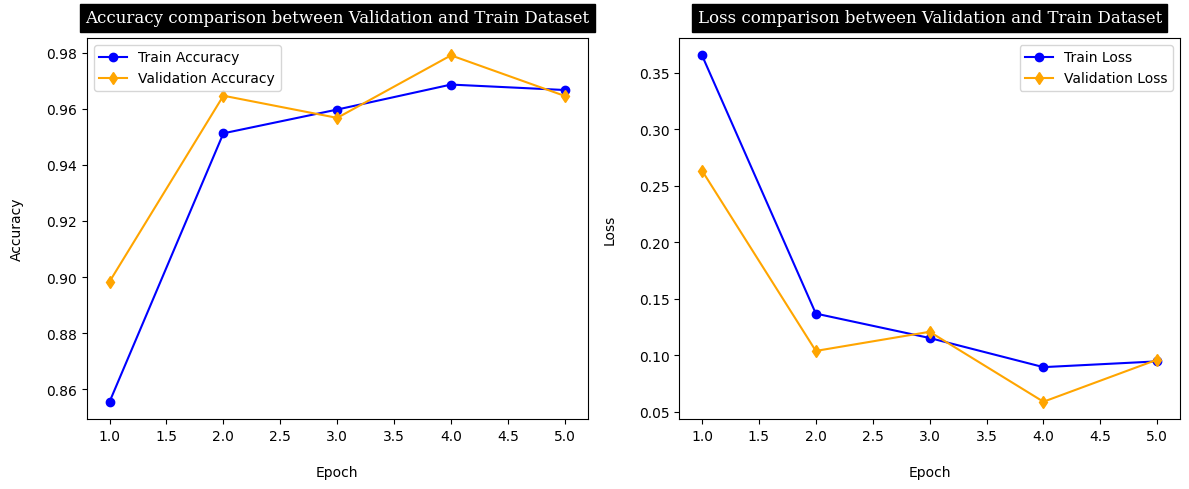

In [27]:
visualizing_results(m2)

              precision    recall  f1-score   support

     Arborio       0.98      0.94      0.96      2253
     Basmati       0.93      0.99      0.96      2248
      Ipsala       1.00      0.99      1.00      2250
     Jasmine       0.97      0.91      0.94      2249
   Karacadag       0.95      0.99      0.97      2250

    accuracy                           0.96     11250
   macro avg       0.96      0.96      0.96     11250
weighted avg       0.96      0.96      0.96     11250
 




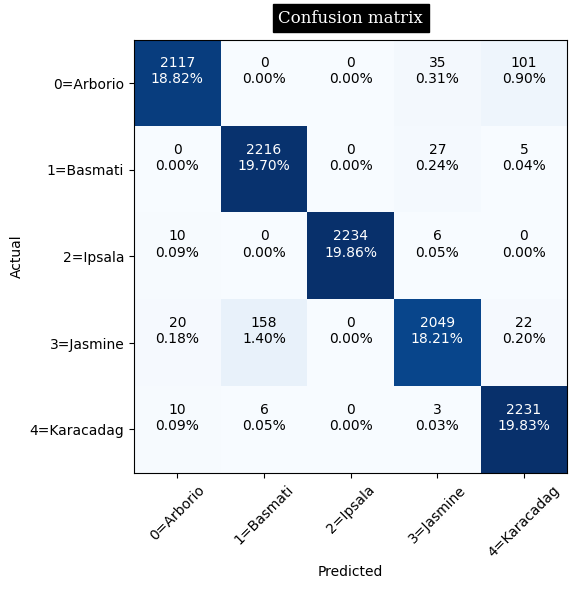

In [28]:
# plot confusion matrix for error analysis
true_labels, predictions = true_and_pred_labels(validation_gen, model2)

print(classification_report(true_labels, predictions, target_names=class_names), '\n\n')
cm = confusion_matrix(true_labels, predictions)

plot_confusion_matrix(cm, classes)

In [29]:
m2_acc = model_evaluation(model2, test_gen)

352/352 ━━━━━━━━━━━━━━━━━━━━ 86s 244ms/step - accuracy: 0.9649 - loss: 0.0996
Test loss: 0.1019
Test accuracy: 0.9628


<a id="5"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> MODEL 3</h1>

In [32]:
# Create a Sequential model3
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Flatten())

model3.add(Dropout(0.5))

model3.add(Dense(256, activation='relu'))
model3.add(Dense(train_gen.num_classes, activation='softmax'))
model3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,766,917 (56.33 MB)

 Trainable params: 14,766,725 (56.33 MB)

 Non-trainable params: 192 (768.00 B)

In [33]:
# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
# Train the model on the training data
m3 = model3.fit(train_gen, epochs=epochs_count, validation_data=validation_gen)

Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1179s 716ms/step - accuracy: 0.7271 - loss: 1.0377 - val_accuracy: 0.7234 - val_loss: 1.6708
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1191s 697ms/step - accuracy: 0.9174 - loss: 0.2421 - val_accuracy: 0.9514 - val_loss: 0.1464
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1158s 705ms/step - accuracy: 0.9364 - loss: 0.1854 - val_accuracy: 0.9023 - val_loss: 0.3140
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1126s 685ms/step - accuracy: 0.9419 - loss: 0.1782 - val_accuracy: 0.8991 - val_loss: 0.3144
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1152s 679ms/step - accuracy: 0.9490 - loss: 0.1541 - val_accuracy: 0.8286 - val_loss: 0.6643


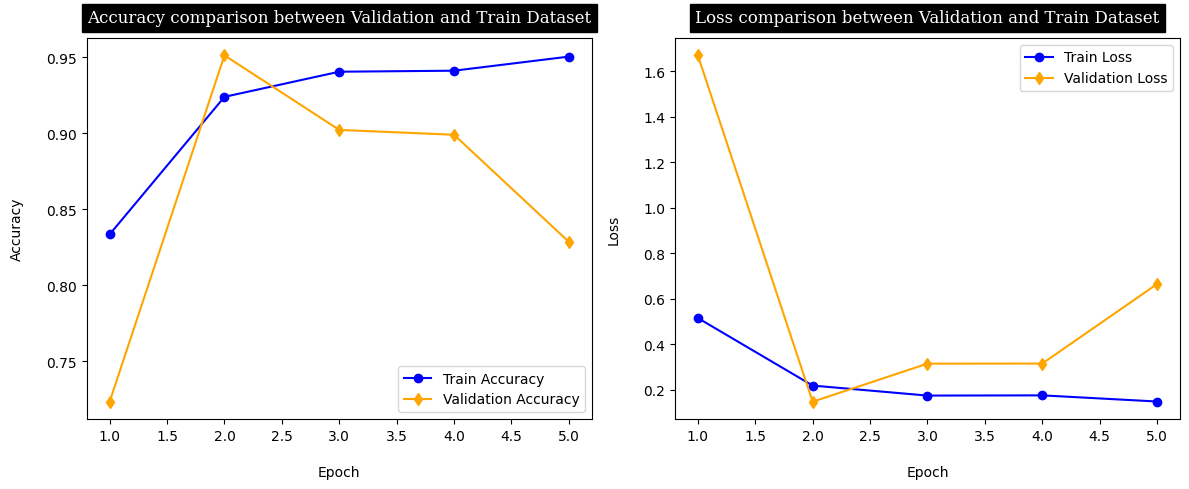

In [35]:
visualizing_results(m3)

              precision    recall  f1-score   support

     Arborio       0.98      0.61      0.75      2247
     Basmati       0.72      1.00      0.84      2243
      Ipsala       1.00      1.00      1.00      2252
     Jasmine       0.95      0.52      0.68      2254
   Karacadag       0.69      1.00      0.81      2254

    accuracy                           0.82     11250
   macro avg       0.87      0.82      0.81     11250
weighted avg       0.87      0.82      0.81     11250
 




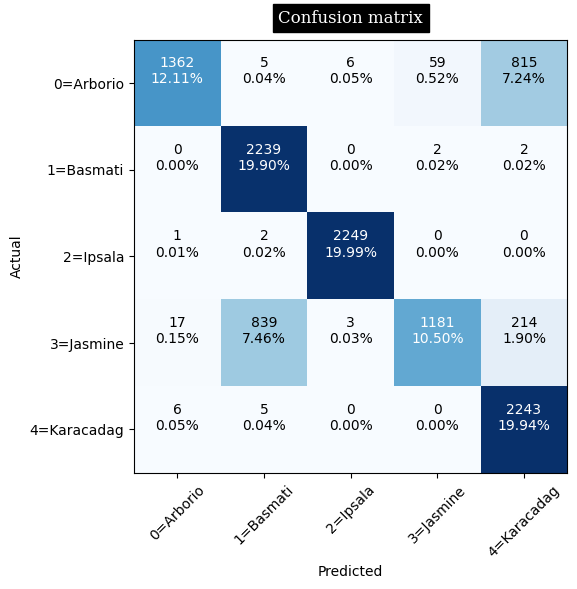

In [36]:
# plot confusion matrix for error analysis
true_labels, predictions = true_and_pred_labels(validation_gen, model3)

print(classification_report(true_labels, predictions, target_names=class_names), '\n\n')
cm = confusion_matrix(true_labels, predictions)

plot_confusion_matrix(cm, classes)

In [37]:
m3_acc = model_evaluation(model3, test_gen)

352/352 ━━━━━━━━━━━━━━━━━━━━ 88s 249ms/step - accuracy: 0.8262 - loss: 0.6521
Test loss: 0.6430
Test accuracy: 0.8278


<a id="6"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> MODEL 4</h1>

In [41]:
# Create a Sequential model4
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten())
model4.add(Dropout(0.5))

model4.add(Dense(256, activation='relu'))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(train_gen.num_classes, activation='softmax'))
model4.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,782,021 (56.39 MB)

 Trainable params: 14,782,021 (56.39 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Compile the model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# Train the model on the training data
m4 = model4.fit(train_gen, epochs=epochs_count, validation_data=validation_gen)

Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1050s 638ms/step - accuracy: 0.6995 - loss: 0.7011 - val_accuracy: 0.9036 - val_loss: 0.2482
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1047s 637ms/step - accuracy: 0.9152 - loss: 0.2208 - val_accuracy: 0.9650 - val_loss: 0.0982
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1103s 638ms/step - accuracy: 0.9505 - loss: 0.1361 - val_accuracy: 0.9400 - val_loss: 0.1651
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1099s 636ms/step - accuracy: 0.9604 - loss: 0.1106 - val_accuracy: 0.9644 - val_loss: 0.0943
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1037s 631ms/step - accuracy: 0.9649 - loss: 0.1000 - val_accuracy: 0.9749 - val_loss: 0.0712


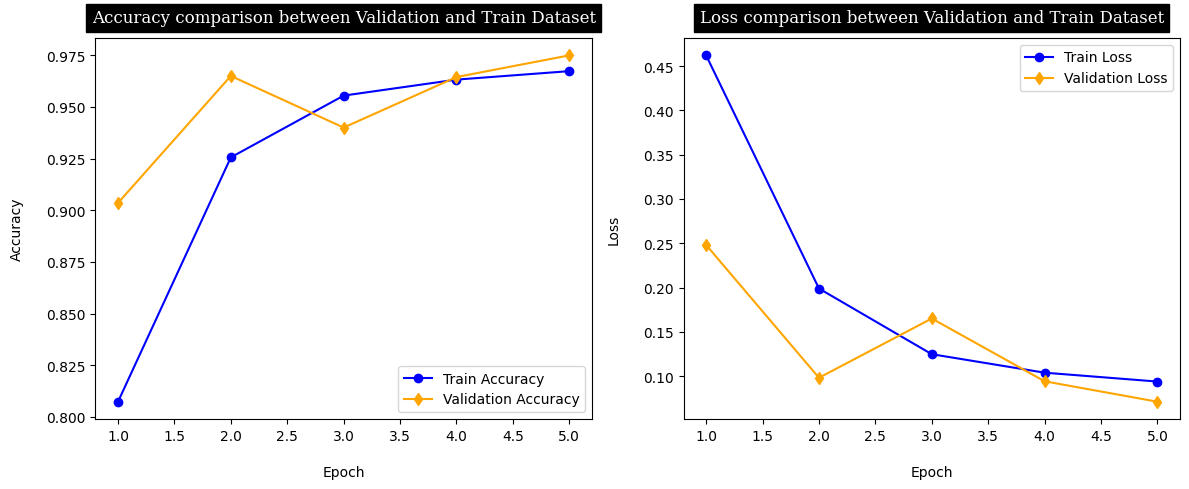

In [44]:
visualizing_results(m4)

              precision    recall  f1-score   support

     Arborio       0.95      0.98      0.97      2238
     Basmati       0.96      0.99      0.97      2250
      Ipsala       1.00      1.00      1.00      2243
     Jasmine       0.98      0.90      0.94      2258
   Karacadag       0.97      0.99      0.98      2261

    accuracy                           0.97     11250
   macro avg       0.97      0.97      0.97     11250
weighted avg       0.97      0.97      0.97     11250
 




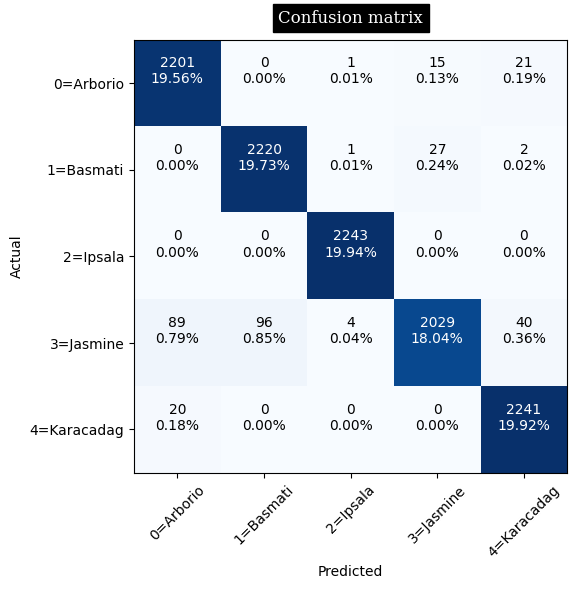

In [45]:
# plot confusion matrix for error analysis
true_labels, predictions = true_and_pred_labels(validation_gen, model4)

print(classification_report(true_labels, predictions, target_names=class_names), '\n\n')
cm = confusion_matrix(true_labels, predictions)

plot_confusion_matrix(cm, classes)

In [46]:
m4_acc = model_evaluation(model4, test_gen)

352/352 ━━━━━━━━━━━━━━━━━━━━ 86s 243ms/step - accuracy: 0.9689 - loss: 0.0853
Test loss: 0.0832
Test accuracy: 0.9699


<a id="7"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> MODEL 5</h1>

In [47]:
# Create a Sequential model5
model5 = Sequential()
model5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model5.add(MaxPooling2D(pool_size=(2, 2)))

model5.add(Flatten())
model5.add(Dropout(0.5))

model5.add(Dense(256, activation='relu'))
model5.add(Dense(64, activation='relu'))
model5.add(Dense(train_gen.num_classes, activation='softmax'))
model5.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 127008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │    32,514,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,531,973 (124.10 MB)

 Trainable params: 32,531,973 (124.10 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Compile the model
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
# Train the model on the training data
m5 = model5.fit(train_gen, epochs=epochs_count, validation_data=validation_gen)

Epoch 1/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1131s 688ms/step - accuracy: 0.7388 - loss: 0.6411 - val_accuracy: 0.9076 - val_loss: 0.2417
Epoch 2/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1163s 688ms/step - accuracy: 0.9121 - loss: 0.2305 - val_accuracy: 0.9165 - val_loss: 0.2070
Epoch 3/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1158s 686ms/step - accuracy: 0.9155 - loss: 0.2212 - val_accuracy: 0.9451 - val_loss: 0.1421
Epoch 4/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1162s 686ms/step - accuracy: 0.9357 - loss: 0.1700 - val_accuracy: 0.9450 - val_loss: 0.1530
Epoch 5/5
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 1130s 688ms/step - accuracy: 0.9423 - loss: 0.1552 - val_accuracy: 0.9639 - val_loss: 0.1006


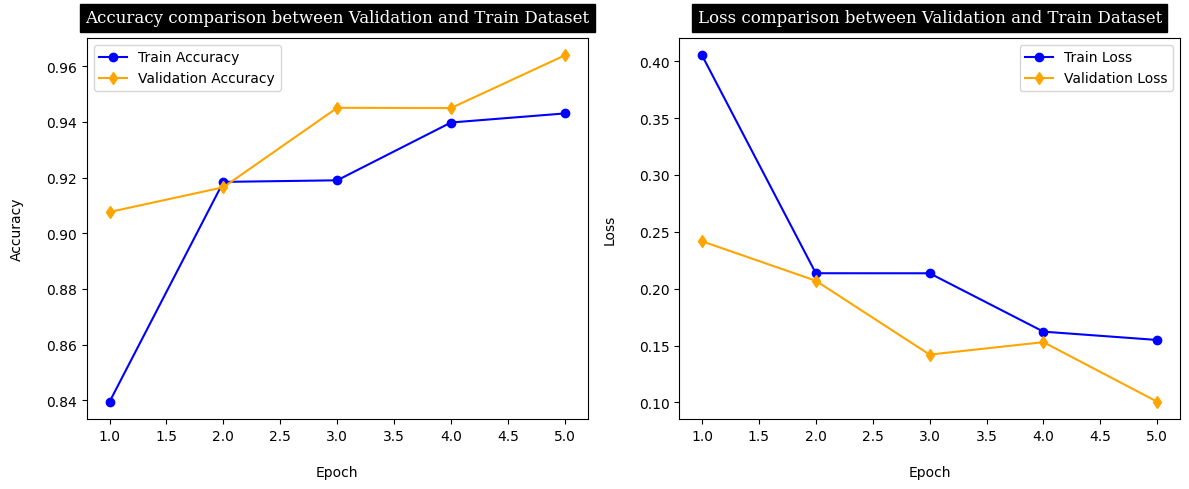

In [50]:
visualizing_results(m5)

              precision    recall  f1-score   support

     Arborio       0.93      0.97      0.95      2246
     Basmati       0.99      0.95      0.97      2241
      Ipsala       1.00      1.00      1.00      2253
     Jasmine       0.93      0.97      0.95      2260
   Karacadag       0.99      0.95      0.97      2250

    accuracy                           0.97     11250
   macro avg       0.97      0.97      0.97     11250
weighted avg       0.97      0.97      0.97     11250
 




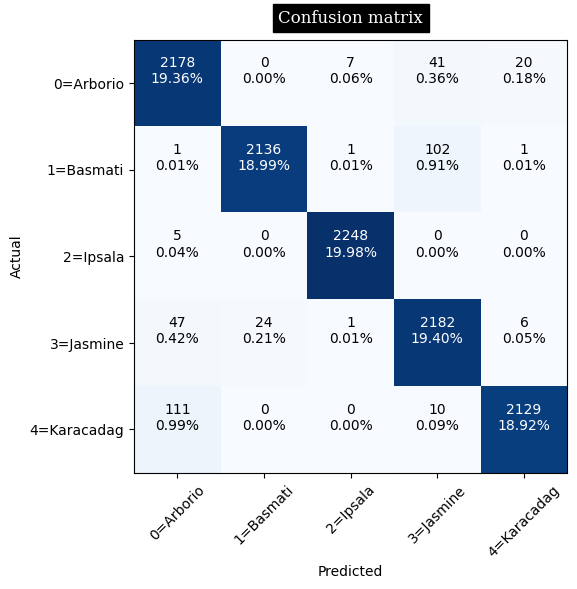

In [51]:
# plot confusion matrix for error analysis
true_labels, predictions = true_and_pred_labels(validation_gen, model5)

print(classification_report(true_labels, predictions, target_names=class_names), '\n\n')
cm = confusion_matrix(true_labels, predictions)

plot_confusion_matrix(cm, classes)

In [52]:
m5_acc = model_evaluation(model5, test_gen)

352/352 ━━━━━━━━━━━━━━━━━━━━ 79s 224ms/step - accuracy: 0.9672 - loss: 0.0932
Test loss: 0.0980
Test accuracy: 0.9659


<a id="8"></a>
<h1 style = 'background-color:#f7e1eb;border:#701356 solid;font-family:newtimeroman;font-size:250%;text-align:center;border-radius:15px 50px; padding:7px'> Comparsion</h1>

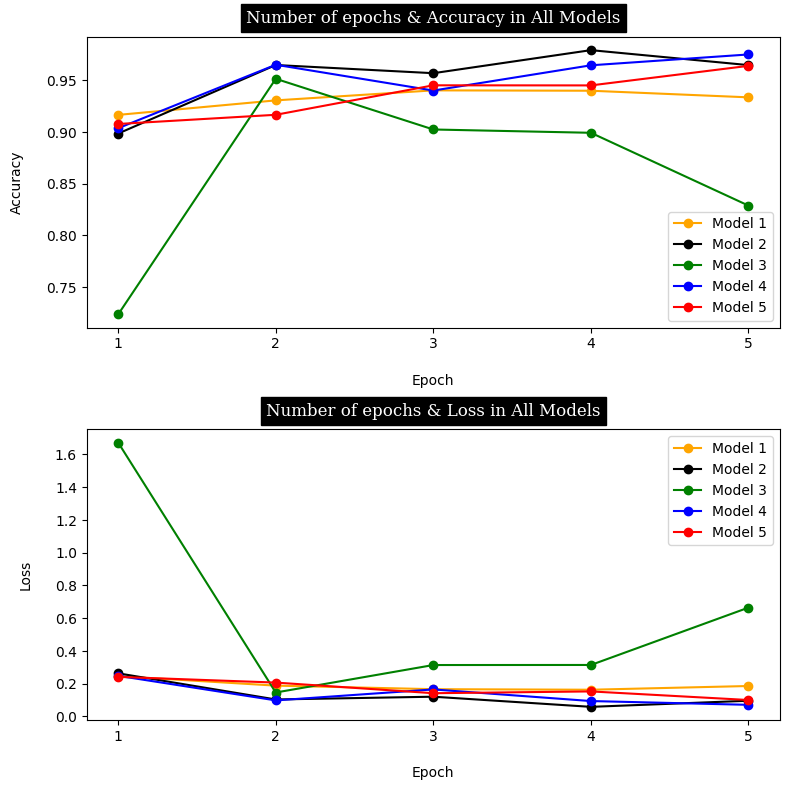

In [56]:
epoch_count = range(1, epochs_count+1)
font = {'family':'serif','size':12}

plt.figure(figsize=(8,8))

plt.subplot(2, 1, 1)
plt.plot(epoch_count, m1.history['val_accuracy'], marker='o', color= 'orange', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m2.history['val_accuracy'], marker='o', color= 'black', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m3.history['val_accuracy'], marker='o', color= 'green', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m4.history['val_accuracy'], marker='o', color= 'blue', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m5.history['val_accuracy'], marker='o', color= 'red', linewidth = '1.5', label='line with marker')

plt.xlabel('Epoch', fontsize=10, labelpad=16)
plt.ylabel('Accuracy', fontsize=10, labelpad=16)
plt.title('Number of epochs & Accuracy in All Models',
              backgroundcolor='black', color='white', fontdict=font, y=1.02)
# plt.xticks(np.arange(1,6,1))
plt.xticks(epoch_count)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], loc='best')

#########################################################

plt.subplot(2, 1, 2)
plt.plot(epoch_count, m1.history['val_loss'], marker='o', color= 'orange', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m2.history['val_loss'], marker='o', color= 'black', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m3.history['val_loss'], marker='o', color= 'green', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m4.history['val_loss'], marker='o', color= 'blue', linewidth = '1.5', label='line with marker')
plt.plot(epoch_count, m5.history['val_loss'], marker='o', color= 'red', linewidth = '1.5', label='line with marker')

plt.xlabel('Epoch', fontsize=10, labelpad=16)
plt.ylabel('Loss', fontsize=10, labelpad=16)
plt.title('Number of epochs & Loss in All Models',
              backgroundcolor='black', color='white', fontdict=font, y=1.02)
# plt.xticks(np.arange(1,6,1))
plt.xticks(epoch_count)
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'], loc='best')

#########################################################
  
plt.tight_layout()
plt.show()

In [57]:
model4.save('my_model.h5')

In [58]:
final_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
final_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │    14,745,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,782,023 (56.39 MB)

 Trainable params: 14,782,021 (56.39 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [59]:
# Evaluate Finanl model and check it
model_evaluation(final_model, test_gen)

352/352 ━━━━━━━━━━━━━━━━━━━━ 87s 244ms/step - accuracy: 0.9712 - loss: 0.0790
Test loss: 0.0858
Test accuracy: 0.9700
